In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from chinese_calendar import is_workday, is_holiday
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline

In [2]:
data_path = '../../data/'

------------
Read Data

In [3]:
tti = pd.read_csv(data_path + 'train_TTI.csv')
tti['time'] = pd.to_datetime(tti['time'])
tti['year'] = tti['time'].dt.year
tti['month'] = tti['time'].dt.month
tti['day'] = tti['time'].dt.day
tti['hour'] = tti['time'].dt.hour
tti['minute'] = tti['time'].dt.minute
tti.head()

,id_road,TTI,speed,time,year,month,day,hour,minute
0,276183,1.03472,69.6197,2019-01-01 00:00:00,2019,1,1,0,0
1,276183,1.03506,69.6275,2019-01-01 00:10:00,2019,1,1,0,10
2,276183,1.04166,69.1003,2019-01-01 00:20:00,2019,1,1,0,20
3,276183,1.02642,70.1266,2019-01-01 00:30:00,2019,1,1,0,30
4,276183,1.01442,70.9565,2019-01-01 00:40:00,2019,1,1,0,40


In [4]:
test_tti = pd.read_csv(data_path + 'toPredict_train_TTI.csv')
test_tti['time'] = pd.to_datetime(test_tti['time'])
test_tti.tail()

,id_road,TTI,speed,time
6043,276738,1.47263,27.9016,2020-01-01 20:10:00
6044,276738,1.47895,27.7825,2020-01-01 20:20:00
6045,276738,1.37184,29.9517,2020-01-01 20:30:00
6046,276738,1.41281,29.0830,2020-01-01 20:40:00
6047,276738,1.57808,26.0371,2020-01-01 20:50:00


In [5]:
pred_tti = pd.read_csv(data_path + 'toPredict_noLabel.csv')
pred_tti['time'] = pd.to_datetime(pred_tti['time'])
pred_tti['year'] = pred_tti['time'].dt.year
pred_tti['month'] = pred_tti['time'].dt.month
pred_tti['day'] = pred_tti['time'].dt.day
pred_tti['hour'] = pred_tti['time'].dt.hour
pred_tti['minute'] = pred_tti['time'].dt.minute
pred_tti.head()

,id_sample,id_road,time,year,month,day,hour,minute
0,0,276183,2019-12-21 08:30:00,2019,12,21,8,30
1,1,276183,2019-12-21 08:40:00,2019,12,21,8,40
2,2,276183,2019-12-21 08:50:00,2019,12,21,8,50
3,3,276183,2019-12-21 10:30:00,2019,12,21,10,30
4,4,276183,2019-12-21 10:40:00,2019,12,21,10,40


In [11]:
is_holiday(time_line['time'][0])

True

In [18]:
time_line = pd.DataFrame({'time': pd.date_range('20191001', '20191221', freq='10min')})
time_line['holiday'] = time_line['time'].apply(is_holiday)*1
time_line['year'] = time_line['time'].dt.year
time_line['month'] = time_line['time'].dt.month
time_line['day'] = time_line['time'].dt.day
time_line.head()

,time,holiday,year,month,day
0,2019-10-01 00:00:00,1,2019,10,1
1,2019-10-01 00:10:00,1,2019,10,1
2,2019-10-01 00:20:00,1,2019,10,1
3,2019-10-01 00:30:00,1,2019,10,1
4,2019-10-01 00:40:00,1,2019,10,1


--------
Pred

In [43]:
tti_datetype = tti.groupby('id_road').apply(lambda x: pd.merge(x, time_line[['time', 'holiday']], how='inner'))
tti_datetype.drop('id_road', inplace=True, axis=1)
tti_datetype.reset_index('id_road', inplace=True)
tti_datetype.head()

,id_road,TTI,speed,time,year,month,day,hour,minute,holiday
0,275911,1.09397,62.7034,2019-10-01 00:00:00,2019,10,1,0,0,1
1,275911,1.09353,62.7287,2019-10-01 00:10:00,2019,10,1,0,10,1
2,275911,1.08355,63.3062,2019-10-01 00:20:00,2019,10,1,0,20,1
3,275911,1.09715,62.5218,2019-10-01 00:30:00,2019,10,1,0,30,1
4,275911,1.07370,63.8872,2019-10-01 00:40:00,2019,10,1,0,40,1


In [48]:
tti_HA = tti_datetype.groupby(['id_road', 'hour', 'minute', 'holiday'])[['TTI']].median()
tti_HA.reset_index(inplace=True)
tti_HA_workday = tti_HA[tti_HA['holiday']==0].drop('holiday', axis=1)
tti_HA_holiday = tti_HA[tti_HA['holiday']==1].drop('holiday', axis=1)
tti_HA_workday.head()

,id_road,hour,minute,TTI
0,275911,0,0,1.07998
2,275911,0,10,1.08135
4,275911,0,20,1.07548
6,275911,0,30,1.07438
8,275911,0,40,1.06793


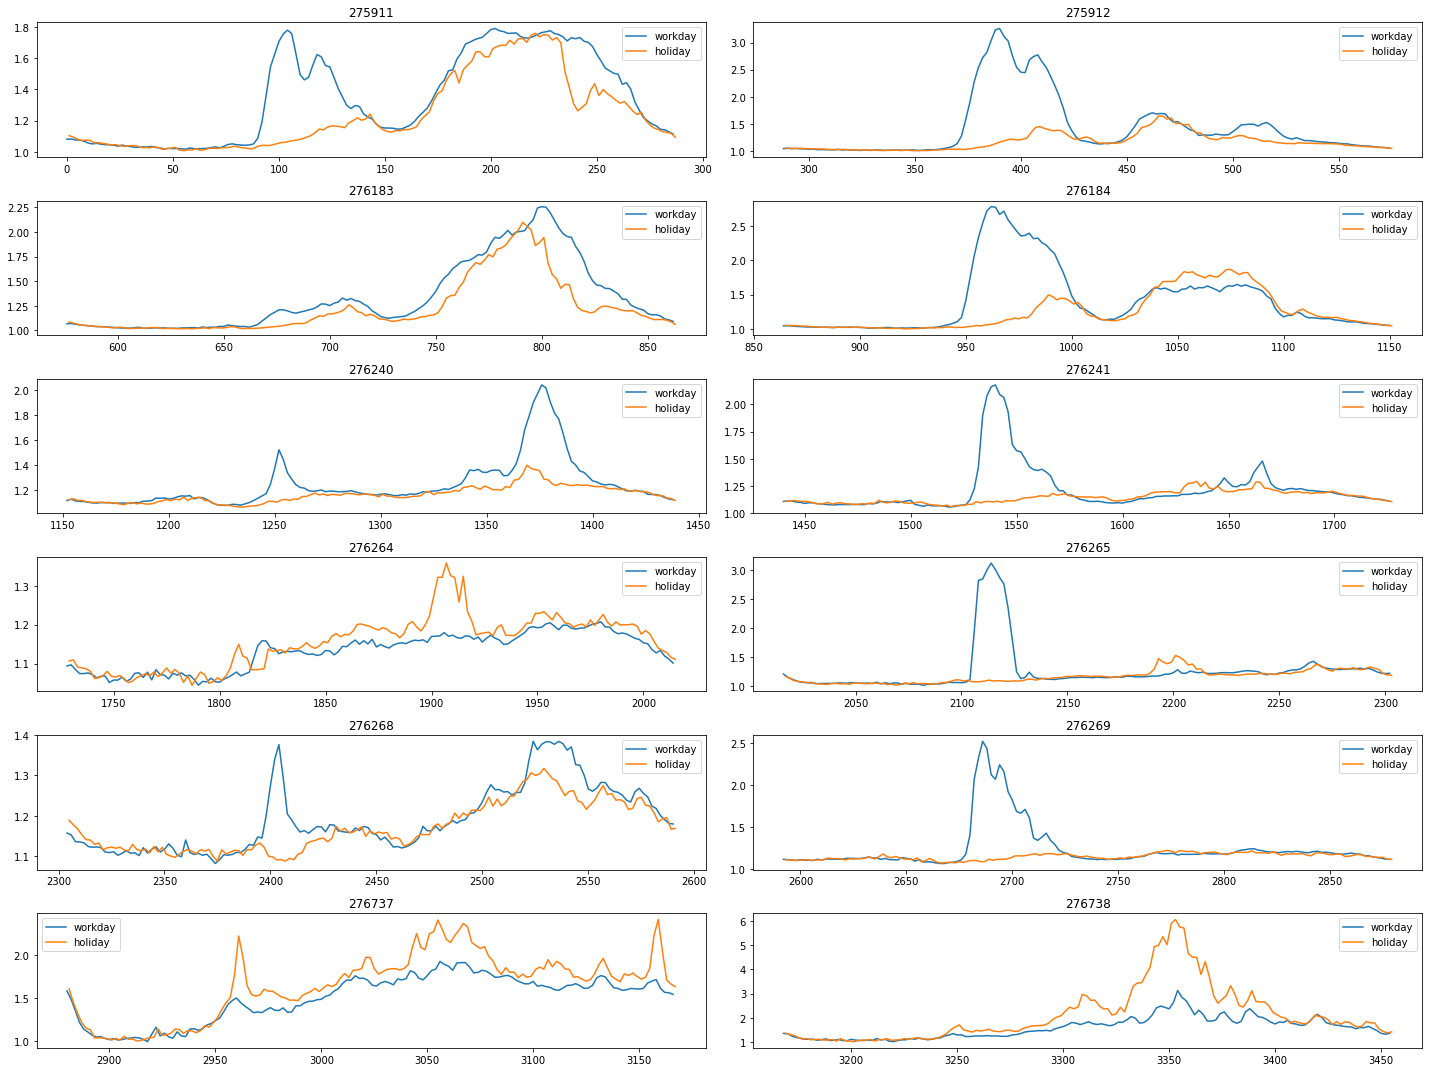

In [49]:
plt.figure(figsize=(20, 15))
for idx, id_road in enumerate(tti_HA_workday['id_road'].unique()):
    plt.subplot(6, 2, idx+1)
    plt.plot(tti_HA_workday[tti_HA_workday['id_road']==id_road]['TTI'], label='workday')
    plt.plot(tti_HA_holiday[tti_HA_holiday['id_road']==id_road]['TTI'], label='holiday')
    plt.legend()
    plt.title(id_road)
plt.tight_layout()

In [50]:
tti_HA_workday['year'] = 2019
tti_HA_workday['month'] = 12
tti_HA_holiday['year'] = 2019
tti_HA_holiday['month'] = 12

In [55]:
tti_202001 = tti[(tti['year']==2019)&(tti['month']==1)].drop(['time', 'speed'], axis=1).copy()
tti_202001['year']=2020
tti_202001.head()

,id_road,TTI,year,month,day,hour,minute
0,276183,1.03472,2020,1,1,0,0
1,276183,1.03506,2020,1,1,0,10
2,276183,1.04166,2020,1,1,0,20
3,276183,1.02642,2020,1,1,0,30
4,276183,1.01442,2020,1,1,0,40


In [56]:
pred = []
pred.append(tti_202001)

for i in [23, 24, 25, 26, 27, 30, 31]:
    tti_HA_workday['day'] = i
    pred.append(tti_HA_workday.copy())
    
for i in [21, 22, 28, 29]:
    tti_HA_holiday['day'] = i
    pred.append(tti_HA_holiday.copy())

    
final_pred = pd.concat(pred)
final_pred.sort_values(['id_road', 'year', 'month', 'day', 'hour', 'minute'], inplace=True)
final_pred.head()

/home/cai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


,TTI,day,hour,id_road,minute,month,year
1,1.102750,21,0,275911,0,12,2019
3,1.093560,21,0,275911,10,12,2019
5,1.079680,21,0,275911,20,12,2019
7,1.072145,21,0,275911,30,12,2019
9,1.073960,21,0,275911,40,12,2019


In [60]:
pred_tti_result = pd.merge(pred_tti, final_pred, on=['id_road', 'year', 'month', 'day', 'hour', 'minute'], how='left')
pred_tti_result[pred_tti_result['id_road']==276183]

,id_sample,id_road,time,year,month,day,hour,minute,TTI
0,0,276183,2019-12-21 08:30:00,2019,12,21,8,30,1.050960
1,1,276183,2019-12-21 08:40:00,2019,12,21,8,40,1.058400
2,2,276183,2019-12-21 08:50:00,2019,12,21,8,50,1.068400
3,3,276183,2019-12-21 10:30:00,2019,12,21,10,30,1.176785
4,4,276183,2019-12-21 10:40:00,2019,12,21,10,40,1.189040
5,5,276183,2019-12-21 10:50:00,2019,12,21,10,50,1.213405
6,6,276183,2019-12-21 12:30:00,2019,12,21,12,30,1.105875
7,7,276183,2019-12-21 12:40:00,2019,12,21,12,40,1.091005
8,8,276183,2019-12-21 12:50:00,2019,12,21,12,50,1.093915
9,9,276183,2019-12-21 14:30:00,2019,12,21,14,30,1.177660


In [61]:
pred_tti_result[['id_sample', 'TTI']].to_csv('../result/method3_cai.csv', index=False)